# TBD - etap 2b

### Michał Kopyt, Rafał Kulus, Adrian Prorok

##  Inicjalizacja sesji sparkowej, załadowanie bibliotek pyspark, SynapseML oraz pysparkling i połączenie do klastra H2O:

In [1]:
pip install h2o_pysparkling_3.2

Note: you may need to restart the kernel to use updated packages.


In [2]:
seed = 20031999

In [3]:
import pyspark
from pyspark.conf import SparkConf

spark = pyspark.sql.SparkSession.builder.appName("tbd") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .getOrCreate()

from pysparkling import *
import h2o
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://76ede72565bc:54323 ... successful.


H2O_cluster_uptime:,13 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,2 days
H2O_cluster_name:,sparkling-water-jovyan_local-1673119682806
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.4-1-3.2
 * H2O name: sparkling-water-jovyan_local-1673119682806
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://76ede72565bc:54323 (CMD + click in Mac OSX)

    


## Importy

In [4]:
from pyspark.sql.functions import col, to_date, month, to_timestamp, hour, regexp_replace
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_auc_score, accuracy_score

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from pysparkling.ml import H2OGLM, H2OXGBoostClassifier, H2OGridSearch
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.train import TrainClassifier, ComputeModelStatistics
from synapse.ml.automl import FindBestModel

## Ładowanie danych

In [69]:
csv_path_1e4 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e4.csv'
csv_path_1e5 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e5.csv'
csv_path_1e6 = 'file:////home/jovyan/work/tbd-notebooks/data/ds1-1e6.csv'

##  Przygotowanie funkcji do ładowania i przygotowania danych na podstawie wybranego pliku:

### Dodane atrybuty

- Month - zastępuje Date z oryginalnych danych, one hot encoding
- Hour - zastępuje Time z oryginalnych danych, one hot encoding

### Zmodyfikowane atrybuty

- Light_Conditions - dla poprawnego działania implementacji z biblioteki SynapseML konieczne było usunięcie znaku ":" z wartości w tej kolumnie

### Usunięte atrybuty

- V1, Accident_Index
- Location_Easting_OSGR, Location_Northing_OSGR
- Accident_Severity
- Date - zastąpione atrybutem Month
- Time - zastąpione atrybutem Hour
- Local_Authority_(District)
- Local_Authority_(Highway)
- 1st_Road_Number, 2nd_Road_Number,
- LSOA_of_Accident_Location,
- Year

### Ostatecznie wybrane cechy wybrane do uczenia i predykcji

- Longitude
- Latitude
- Police_Force
- Number_of_Vehicles
- Number_of_Casualties
- Speed_limit
- Day_of_Week (one hot encoding)
- 1st_Road_Class (one hot encoding)
- Road_Type (one hot encoding)
- Junction_Control (one hot encoding)
- 2nd_Road_Class (one hot encoding)
- Pedestrian_Crossing-Human_Control (one hot encoding)
- Pedestrian_Crossing-Physical_Facilities (one hot encoding)
- Light_Conditions (one hot encoding)
- Weather_Conditions (one hot encoding)
- Road_Surface_Conditions (one hot encoding)
- Special_Conditions_at_Site (one hot encoding)
- Carriageway_Hazards (one hot encoding)
- Urban_or_Rural_Area (one hot encoding)
- Did_Police_Officer_Attend_Scene_of_Accident (one hot encoding)
- Month (one hot encoding)
- Hour (one hot encoding)

### **W otrzymanym zbiorze danych znajduje się atrybut "Accident_Severity", który idealnie mapuje się na naszą zmienną objaśnianą. Samo jego użycie dało by nam najlepsze możliwe do uzyskania wyniki modeli, jednak z oczywistych przyczyn na potrzeby zadania zrezygnowaliśmy z niego.**

In [6]:
def get_features_df(csv_path):
    df = spark.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')
    df = df.filter('Longitude is not NULL and Latitude is not NULL')
    df = df.withColumn('label', df.label.cast('integer'))
    
    df = df.withColumn('Date', to_date(df.Date, 'dd/MM/yyyy'))
    df = df.withColumn('Month', month(df.Date))
    df = df.withColumn('Time', to_timestamp(df.Time, 'HH:mm'))
    df = df.withColumn('Hour', hour(df.Time))
    
    df = df.withColumn('Light_Conditions', regexp_replace('Light_Conditions', ':', ''))
    
    df = df.drop('V1', 'Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Accident_Severity', 'Date', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Number', '2nd_Road_Number', 'LSOA_of_Accident_Location', 'Year')
    
    columns_for_one_hot_encoding = ['Day_of_Week', '1st_Road_Class', 'Road_Type', 'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Month', 'Hour']
    other_columns = ['Longitude', 'Latitude', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']

    stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in columns_for_one_hot_encoding]
    onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in columns_for_one_hot_encoding]

    extracted_columns = ['onehot_' + c for c in columns_for_one_hot_encoding]
    vectorassembler_stage = VectorAssembler(inputCols=extracted_columns + other_columns, outputCol='features')
    
    pipeline_stages = stringindexer_stages + onehotencoder_stages + [vectorassembler_stage]
    
    return Pipeline(stages=pipeline_stages).fit(df).transform(df).select(['features', 'label'])

## Dodatkowe klasy i funkcje do eksperymentów

In [7]:
class ModelTestingResults:
  def __init__(self, training_time = 0, auc = 0, accuracy = 0, confusion_matrix = None):
    self.training_time = training_time
    self.auc = auc
    self.accuracy = accuracy
    self.confusion_matrix = confusion_matrix

class ModelTuningResults:
  def __init__(self, tuned_params = {}, auc = 0, accuracy = 0, confusion_matrix = None):
    self.tuned_params = tuned_params
    self.auc = auc
    self.accuracy = accuracy
    self.confusion_matrix = confusion_matrix

def get_confusion_matrix(predictions_df):
    return predictions_df.select('label', 'prediction').groupBy('label', 'prediction').count().sort(col('label'), col('prediction')).toPandas()

def get_confusion_matrix_sklearn(testing_df, sklearn_pred):
    Y_testing = testing_df.select('label').toPandas().to_numpy().ravel()
    predictions_df = pd.DataFrame(data={'prediction': sklearn_pred, 'label': Y_testing})
    return predictions_df.groupby(['label','prediction'])[['label','prediction']].size().reset_index(name='count').sort_values(by=['label', 'prediction']).reset_index(drop=True)

def print_model_testing_results(model_testing_results, label):
    if label:
        print(f'----- {label} -----')
    print(f'Czas trenowania: {round(model_testing_results.training_time, 3)}s')
    print(f'AUC: {round(model_testing_results.auc, 3)}')
    print(f'Accuracy: {round(model_testing_results.accuracy, 3)}')
    print('Macierz pomyłek:')
    print(model_testing_results.confusion_matrix)

    
def print_model_tuning_results(model_tuning_results, label):
    if label:
        print(f'----- {label} -----')
    if model_tuning_results.tuned_params:
        print('Zoptymalizowane parametry:')
        for param in model_tuning_results.tuned_params.keys():
            if type(model_tuning_results.tuned_params[param] == str):
                print(f'    {param}: {model_tuning_results.tuned_params[param]}')
            else:
                print(f'    {param}: {round(model_tuning_results.tuned_params[param], 3)}')
    print(f'AUC: {round(model_tuning_results.auc, 3)}')
    print(f'Accuracy: {round(model_tuning_results.accuracy, 3)}')
    print('Macierz pomyłek:')
    print(model_tuning_results.confusion_matrix)

# Przygotowanie funkcji do testowania modeli

W poniższej sekcji przygotowaliśmy funkcje służące do trenowania odpowiednich modeli, ich testowania oraz przygotowania w zwięzłej formie wyników badań dla poszczególnych podpunktów niniejszego sprawozdania.

## sparkML

In [8]:
sparkML_evaluator_auroc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
sparkML_evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

def test_sparkML(base_model, training_df, testing_df):
    training_start_time = timer()
    model = base_model.fit(training_df)
    training_end_time = timer()
    
    prediction_df = model.transform(testing_df)
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def test_sparkML_lr_basic_version(training_df, testing_df):
    sparkML_lr = LogisticRegression()
    return test_sparkML(sparkML_lr, training_df, testing_df)

def test_sparkML_gbt_basic_version(training_df, testing_df):
    sparkML_gbt = GBTClassifier()
    return test_sparkML(sparkML_gbt, training_df, testing_df)

def tune_and_test_sparkML_lr(training_df, testing_df):
    sparkML_lr = LogisticRegression()

    param_grid = ParamGridBuilder() \
        .addGrid(sparkML_lr.regParam,[0.0, 0.005, 0.01, 0.015, 0.02, 0.025]) \
        .addGrid(sparkML_lr.elasticNetParam, [0.0, 0.5, 0.55, 0.6, 0.65, 0.7]) \
        .build()
    cv = CrossValidator(estimator=sparkML_lr, estimatorParamMaps=param_grid, evaluator=sparkML_evaluator_auroc, numFolds=4)
    cv_model = cv.fit(training_df)
    best_model = cv_model.bestModel

    prediction_df = best_model.transform(testing_df)
    tuned_params = {
        'regParam': best_model.extractParamMap().get(sparkML_lr.regParam),
        'elasticNetParam': best_model.extractParamMap().get(sparkML_lr.elasticNetParam)
    }
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def tune_and_test_sparkML_gbt(training_df, testing_df):
    sparkML_gbt = GBTClassifier()
    
    param_grid = ParamGridBuilder() \
        .addGrid(sparkML_gbt.maxDepth, [5, 10, 15]) \
        .addGrid(sparkML_gbt.maxBins, [16, 32, 64]) \
        .build()
    cv = CrossValidator(estimator=sparkML_gbt, estimatorParamMaps=param_grid, evaluator=sparkML_evaluator_auroc, numFolds=4)
    cv_model = cv.fit(training_df)
    best_model = cv_model.bestModel

    prediction_df = best_model.transform(testing_df)
    tuned_params = {
        'maxDepth': best_model.extractParamMap().get(sparkML_gbt.maxDepth),
        'maxBins': best_model.extractParamMap().get(sparkML_gbt.maxBins)
    }
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

## H2O-sparklinkg-water

In [9]:
def test_h2o(base_model, training_df, testing_df):
    training_start_time = timer()
    model = base_model.fit(training_df)
    training_end_time = timer()
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )
    
def test_h2o_lr_basic_version(training_df, testing_df):
    h2o_lr = H2OGLM(
        family="binomial",
        featuresCols=['features'],
        labelCol='label'
    )
    return test_h2o(h2o_lr, training_df, testing_df)

def test_h2o_gbt_basic_version(training_df, testing_df):
    h2o_gbt = H2OXGBoostClassifier(featuresCols=['features'], labelCol='label')
    return test_h2o(h2o_gbt, training_df, testing_df)

def tune_and_test_h2o_lr(training_df, testing_df):
    h2o_lr = H2OGLM(
        family="binomial",
        featuresCols=['features'],
        labelCol='label'
    )
    
    param_grid = {
        'alphaValue': [0.0, 0.5, 1.0] ,
        'lambdaValue': [0.0, 0.5, 1.0]
    }
    
    grid_search = H2OGridSearch(hyperParameters=param_grid, algo=h2o_lr, strategy="Cartesian")
    model = grid_search.fit(training_df)
    
    tuned_params = {
        'alphaValue': model.getAlphaValue()[0],
        'lambdaValue': model.getLambdaValue()[0]
    }
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

def tune_and_test_h2o_gbt(training_df, testing_df):
    h2o_gbt = H2OXGBoostClassifier(featuresCols=['features'], labelCol='label')
    
    param_grid = {
        'learnRate': [0.05, 0.1, 0.2, 0.3, 0.4],
        'maxDepth': [0, 6],
    }
    
    grid_search = H2OGridSearch(hyperParameters=param_grid, algo=h2o_gbt, strategy="Cartesian")
    model = grid_search.fit(training_df)
    
    tuned_params = {
        'learnRate': model.getLearnRate(),
        'maxDepth': model.getMaxDepth()
    }
    
    prediction_df = model.transform(testing_df)
    predicted_labels_for_testing_data = prediction_df.withColumn('prediction', prediction_df.prediction.cast('int')).select('prediction').toPandas().to_numpy().ravel()
    labels_for_testing_data = prediction_df.select('label').toPandas().to_numpy().ravel()
    probabilities_for_1 = prediction_df.withColumn('detailed_prediction', col('detailed_prediction').probabilities['1']).select('detailed_prediction').toPandas().to_numpy().ravel()
    
    return ModelTuningResults(
        tuned_params=tuned_params,
        auc=roc_auc_score(labels_for_testing_data, probabilities_for_1),
        accuracy=accuracy_score(labels_for_testing_data, predicted_labels_for_testing_data),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

## scikit-learn (do implementacji nierozproszonej)

In [10]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def get_sklearn_X_and_y(data_df):
    features_num = data_df.first().features.size
    X = data_df.withColumn('x', vector_to_array('features')).select([col('x')[i] for i in range(features_num)]).toPandas()
    y = data_df.select('label').toPandas().to_numpy().ravel()
    return X, y

def test_sklearn_lr_basic_version(training_df, testing_df):
    sklearn_lr = SklearnLogisticRegression()
    
    training_start_time = timer()
    X, y = get_sklearn_X_and_y(training_df)
    model = sklearn_lr.fit(X, y)
    training_end_time = timer()
    
    X_testing, y_testing = get_sklearn_X_and_y(testing_df)
    prediction_df = model.predict(X_testing)
    
    return ModelTestingResults(
        training_time=training_end_time - training_start_time,
        auc=roc_auc_score(y_testing, model.predict_proba(X_testing)[::, 1]),
        accuracy=accuracy_score(y_testing, prediction_df),
        confusion_matrix=get_confusion_matrix_sklearn(testing_df, prediction_df)
    )

def tune_and_test_sklearn_lr(training_df, testing_df):
    sklearn_lr = SklearnLogisticRegression(max_iter=10000)
    
    param_grid = {
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1.0, 10, 100]
    }
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=sklearn_lr, param_grid=param_grid, cv=cv, scoring='roc_auc',error_score=0)
    X, y = get_sklearn_X_and_y(training_df)
    model = grid_search.fit(X, y)
        
    X_testing, y_testing = get_sklearn_X_and_y(testing_df)
    prediction_df = model.predict(X_testing)
    
    return ModelTuningResults(
        tuned_params=model.best_params_,
        auc=roc_auc_score(y_testing, model.predict_proba(X_testing)[::, 1]),
        accuracy=accuracy_score(y_testing, prediction_df),
        confusion_matrix=get_confusion_matrix_sklearn(testing_df, prediction_df)
    )

## SynapseML

In [11]:
def test_synapseML(base_model, training_df, testing_df):
    return test_sparkML(base_model, training_df, testing_df) # Ten sam kod

def test_synapseML_gbt_basic_version(training_df, testing_df):
    synapseML_gbt = LightGBMClassifier(objective="binary", featuresCol="features", labelCol="label")
    return test_synapseML(synapseML_gbt, training_df, testing_df)

def tune_and_test_synapseML_gbt(training_df, testing_df):
    learning_rates = [0.05, 0.1, 0.2, 0.4]
    synapseML_gbt_list = [
        LightGBMClassifier(objective="binary", featuresCol="features", labelCol="label", learningRate=lr) for lr in learning_rates
    ]
    synapseML_gbt_models = [
        TrainClassifier(model=gbt, labelCol='label').fit(training_df) for gbt in synapseML_gbt_list
    ]    
    model = FindBestModel(evaluationMetric="AUC", models=synapseML_gbt_models).fit(testing_df)
    prediction_df = model.transform(testing_df)
    
    return ModelTuningResults(
        auc=sparkML_evaluator_auroc.evaluate(prediction_df),
        accuracy=sparkML_evaluator_accuracy.evaluate(prediction_df),
        confusion_matrix=get_confusion_matrix(prediction_df)
    )

# **Regresja logistyczna - porównanie wyników klasyfikacji oraz czasu trenowania podstawowych wersji modeli dla różnych wielkości zbiorów danych**

Dla każdego otrzymanego zbioru danych, przeprowadziliśmy trenowanie podstawowych wersji (z domyślnymi parametrami) modelów typu regresja logistyczna. Ich implementacje zaczerpnęliśmy z trzech bibliotek: Spark, h2o-sparkling-water oraz scikit-learn (implementacja nierozproszona). Podczas trenowania mierzyliśmy jego czas, a następnie dla otrzymanych modeli sprawdziliśmy na zbiorze testowym wartości AUC, Accuracy oraz macierz pomyłek.

## Zbiór danych 1e4

In [12]:
training_df_1e4, testing_df_1e4 = get_features_df(csv_path_1e4).randomSplit([0.8, 0.2], seed=seed)

In [13]:
sparkML_lr_basic_1e4_results = test_sparkML_lr_basic_version(training_df_1e4, testing_df_1e4)

label_sparkML_lr_basic_1e4_results = 'Regresja logistyczna, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e4_results, label_sparkML_lr_basic_1e4_results)

----- Regresja logistyczna, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 4.527s
AUC: 0.63
Accuracy: 0.667
Macierz pomyłek:
   label  prediction  count
0      0         1.0      3
1      1         0.0      1
2      1         1.0      8


In [14]:
h2o_lr_basic_1e4_results = test_h2o_lr_basic_version(training_df_1e4, testing_df_1e4)

label_h2o_lr_basic_1e4_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e4_results, label_h2o_lr_basic_1e4_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 6.117s
AUC: 0.556
Accuracy: 0.75
Macierz pomyłek:
   label prediction  count
0      0          0      1
1      0          1      2
2      1          0      1
3      1          1      8


In [15]:
sklearn_lr_basic_1e4_results = test_sklearn_lr_basic_version(training_df_1e4, testing_df_1e4)

label_sklearn_lr_basic_1e4_results = 'Regresja logistyczna, scikit-learn, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e4_results, label_sklearn_lr_basic_1e4_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.966s
AUC: 0.593
Accuracy: 0.667
Macierz pomyłek:
   label  prediction  count
0      0           1      3
1      1           0      1
2      1           1      8


## Zbiór danych 1e5

In [16]:
training_df_1e5, testing_df_1e5 = get_features_df(csv_path_1e5).randomSplit([0.8, 0.2], seed=seed)

In [17]:
sparkML_lr_basic_1e5_results = test_sparkML_lr_basic_version(training_df_1e5, testing_df_1e5)

label_sparkML_lr_basic_1e5_results = 'Regresja logistyczna, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e5_results, label_sparkML_lr_basic_1e5_results)

----- Regresja logistyczna, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 2.727s
AUC: 0.874
Accuracy: 0.946
Macierz pomyłek:
   label  prediction  count
0      0         0.0      8
1      0         1.0      2
2      1         1.0     27


In [18]:
h2o_lr_basic_1e5_results = test_h2o_lr_basic_version(training_df_1e5, testing_df_1e5)

label_h2o_lr_basic_1e5_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e5_results, label_h2o_lr_basic_1e5_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.447s
AUC: 0.837
Accuracy: 0.865
Macierz pomyłek:
   label prediction  count
0      0          0      5
1      0          1      5
2      1          1     27


In [19]:
sklearn_lr_basic_1e5_results = test_sklearn_lr_basic_version(training_df_1e5, testing_df_1e5)

label_sklearn_lr_basic_1e5_results = 'Regresja logistyczna, scikit-learn, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e5_results, label_sklearn_lr_basic_1e5_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 3.384s
AUC: 0.856
Accuracy: 0.838
Macierz pomyłek:
   label  prediction  count
0      0           0      4
1      0           1      6
2      1           1     27


## Zbiór danych 1e6

In [20]:
training_df_1e6, testing_df_1e6 = get_features_df(csv_path_1e6).randomSplit([0.8, 0.2], seed=seed)

In [21]:
sparkML_lr_basic_1e6_results = test_sparkML_lr_basic_version(training_df_1e6, testing_df_1e6)

label_sparkML_lr_basic_1e6_results = 'Regresja logistyczna, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_lr_basic_1e6_results, label_sparkML_lr_basic_1e6_results)

----- Regresja logistyczna, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 2.117s
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         1.0     68


In [22]:
h2o_lr_basic_1e6_results = test_h2o_lr_basic_version(training_df_1e6, testing_df_1e6)

label_h2o_lr_basic_1e6_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_lr_basic_1e6_results, label_h2o_lr_basic_1e6_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.477s
AUC: 0.975
Accuracy: 0.964
Macierz pomyłek:
   label prediction  count
0      0          0     16
1      1          0      3
2      1          1     65


In [23]:
sklearn_lr_basic_1e6_results = test_sklearn_lr_basic_version(training_df_1e6, testing_df_1e6)

label_sklearn_lr_basic_1e6_results = 'Regresja logistyczna, scikit-learn, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sklearn_lr_basic_1e6_results, label_sklearn_lr_basic_1e6_results)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


----- Regresja logistyczna, scikit-learn, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.299s
AUC: 0.944
Accuracy: 0.881
Macierz pomyłek:
   label  prediction  count
0      0           0     12
1      0           1      4
2      1           0      6
3      1           1     62


## Analiza wyników

In [24]:
models_lr_basic_scores_data = [
    ['1e4', 'sparkML', sparkML_lr_basic_1e4_results.training_time, sparkML_lr_basic_1e4_results.auc, sparkML_lr_basic_1e4_results.accuracy],
    ['1e4', 'h2o-sparkling-water', h2o_lr_basic_1e4_results.training_time, h2o_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.accuracy],
    ['1e4', 'scikit-learn', sklearn_lr_basic_1e4_results.training_time, sklearn_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.accuracy],
    ['1e5', 'sparkML', sparkML_lr_basic_1e5_results.training_time, sparkML_lr_basic_1e5_results.auc, sparkML_lr_basic_1e5_results.accuracy],
    ['1e5', 'h2o-sparkling-water', h2o_lr_basic_1e5_results.training_time, h2o_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.accuracy],
    ['1e5', 'scikit-learn', sklearn_lr_basic_1e5_results.training_time, sklearn_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.accuracy],
    ['1e6', 'sparkML', sparkML_lr_basic_1e6_results.training_time, sparkML_lr_basic_1e6_results.auc, sparkML_lr_basic_1e6_results.accuracy],
    ['1e6', 'h2o-sparkling-water', h2o_lr_basic_1e6_results.training_time, h2o_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.accuracy],
    ['1e6', 'scikit-learn', sklearn_lr_basic_1e6_results.training_time, sklearn_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.accuracy],
]

models_lr_basic_scores_df = pd.DataFrame(models_lr_basic_scores_data, columns=['Zbiór danych', 'Biblioteka', 'Czas trenowania (s)', 'AUC', 'Accuracy'])
models_lr_basic_scores_df

,Zbiór danych,Biblioteka,Czas trenowania (s),AUC,Accuracy
0,1e4,sparkML,4.527200,0.629630,0.666667
1,1e4,h2o-sparkling-water,6.116594,0.555556,0.750000
2,1e4,scikit-learn,1.966072,0.592593,0.666667
3,1e5,sparkML,2.726768,0.874074,0.945946
4,1e5,h2o-sparkling-water,1.446742,0.837037,0.864865
5,1e5,scikit-learn,3.384161,0.855556,0.837838
6,1e6,sparkML,2.117332,1.000000,1.000000
7,1e6,h2o-sparkling-water,1.477032,0.975184,0.964286
8,1e6,scikit-learn,1.298521,0.943934,0.880952


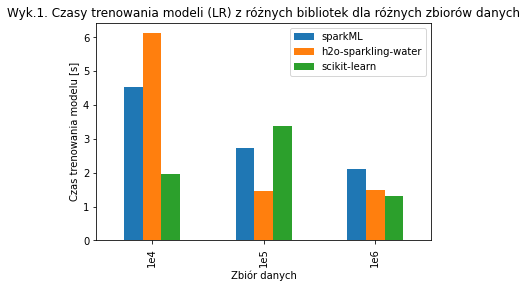

In [25]:
lr_basic_models_training_times_data = [
    [sparkML_lr_basic_1e4_results.training_time, h2o_lr_basic_1e4_results.training_time, sklearn_lr_basic_1e4_results.training_time],
    [sparkML_lr_basic_1e5_results.training_time, h2o_lr_basic_1e5_results.training_time, sklearn_lr_basic_1e5_results.training_time],
    [sparkML_lr_basic_1e6_results.training_time, h2o_lr_basic_1e6_results.training_time, sklearn_lr_basic_1e6_results.training_time],
]

lr_basic_models_training_times_df = pd.DataFrame(lr_basic_models_training_times_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_training_times_df.plot.bar()
plt.title('Wyk.1. Czasy trenowania modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

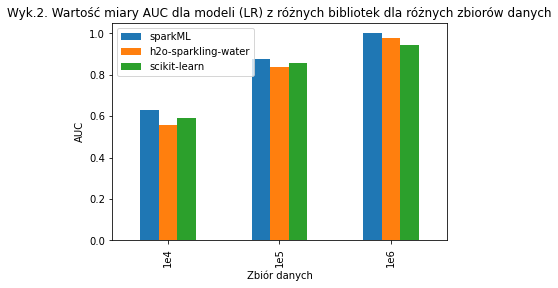

In [26]:
lr_basic_models_auc_data = [
    [sparkML_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.auc],
    [sparkML_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.auc],
    [sparkML_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.auc],
]

lr_basic_models_auc_df = pd.DataFrame(lr_basic_models_auc_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_auc_df.plot.bar()
plt.title('Wyk.2. Wartość miary AUC dla modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

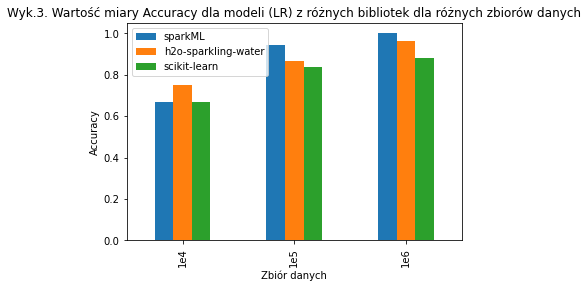

In [27]:
lr_basic_models_accuracy_data = [
    [sparkML_lr_basic_1e4_results.accuracy, h2o_lr_basic_1e4_results.accuracy, sklearn_lr_basic_1e4_results.accuracy],
    [sparkML_lr_basic_1e5_results.accuracy, h2o_lr_basic_1e5_results.accuracy, sklearn_lr_basic_1e5_results.accuracy],
    [sparkML_lr_basic_1e6_results.accuracy, h2o_lr_basic_1e6_results.accuracy, sklearn_lr_basic_1e6_results.accuracy],
]

lr_basic_models_accuracy_df = pd.DataFrame(lr_basic_models_accuracy_data, columns=['sparkML', 'h2o-sparkling-water', 'scikit-learn'], index=['1e4', '1e5', '1e6'])

lr_basic_models_accuracy_df.plot.bar()
plt.title('Wyk.3. Wartość miary Accuracy dla modeli (LR) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

# **Regresja logistyczna - optymalizacja hiperparametrów modeli na zbiorze danych 1e6**

Dla każdej badanej implementacji modelu typu regresja logistyczna, spróbowaliśmy dokonać optymalizacji ich parametrów. Wyniki dla nowo otrzymanych modeli porównaliśmy z ich wersjami bazowymi. Optymalizację, trenowanie i testowanie modeli przeprowadziliśmy na zbiorze danych 1e6.

Dla każdej biblioteki dokonaliśmy optymalizacji dla różnych parametrów, z wykorzystaniem metod detykowanych dla tych bibliotek. Szczegóły w implementacjach kolejnych wywoływanych funkcji.

## sparkML

In [28]:
sparkML_lr_tuning_1e6_results = tune_and_test_sparkML_lr(training_df_1e6, testing_df_1e6)


label_sparkML_lr_tuning_1e6_results = 'Regresja logistyczna, sparkML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sparkML_lr_tuning_1e6_results, label_sparkML_lr_tuning_1e6_results)

----- Regresja logistyczna, sparkML, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    regParam: 0.005
    elasticNetParam: 0.0
AUC: 1.0
Accuracy: 0.964
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         0.0      3
2      1         1.0     65


## H2O-sparklinkg-water

In [29]:
h2o_lr_tuning_1e6_results = tune_and_test_h2o_lr(training_df_1e6, testing_df_1e6)


label_h2o_lr_tuning_1e6_results = 'Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(h2o_lr_tuning_1e6_results, label_h2o_lr_tuning_1e6_results)

----- Regresja logistyczna, H2O-sparkling-water, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    alphaValue: 0.0
    lambdaValue: 0.0
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label prediction  count
0      0          0     16
1      1          1     68


## scikit-learn

In [30]:
sklearn_lr_tuning_1e6_results = tune_and_test_sklearn_lr(training_df_1e6, testing_df_1e6)


label_sklearn_lr_tuning_1e6_results = 'Regresja logistyczna, scikit-learn, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sklearn_lr_tuning_1e6_results, label_sklearn_lr_tuning_1e6_results)

----- Regresja logistyczna, scikit-learn, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    C: 10
    penalty: l2
    solver: liblinear
AUC: 1.0
Accuracy: 0.964
Macierz pomyłek:
   label  prediction  count
0      0           0     16
1      1           0      3
2      1           1     65


## Analiza wyników

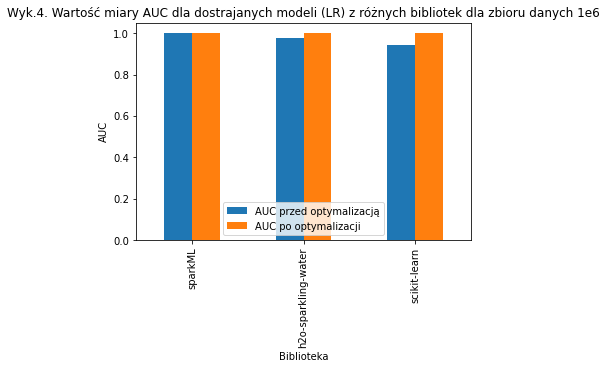

In [31]:
lr_tuned_models_auc_data = [
    [sparkML_lr_basic_1e6_results.auc, sparkML_lr_tuning_1e6_results.auc],
    [h2o_lr_basic_1e6_results.auc, h2o_lr_tuning_1e6_results.auc],
    [sklearn_lr_basic_1e6_results.auc, sklearn_lr_tuning_1e6_results.auc]
]

lr_tuned_models_auc_df = pd.DataFrame(lr_tuned_models_auc_data, columns=['AUC przed optymalizacją', 'AUC po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_tuned_models_auc_df.plot.bar()
plt.title('Wyk.4. Wartość miary AUC dla dostrajanych modeli (LR) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [32]:
lr_tuned_models_auc_df

,AUC przed optymalizacją,AUC po optymalizacji
sparkML,1.000000,1.0
h2o-sparkling-water,0.975184,1.0
scikit-learn,0.943934,1.0


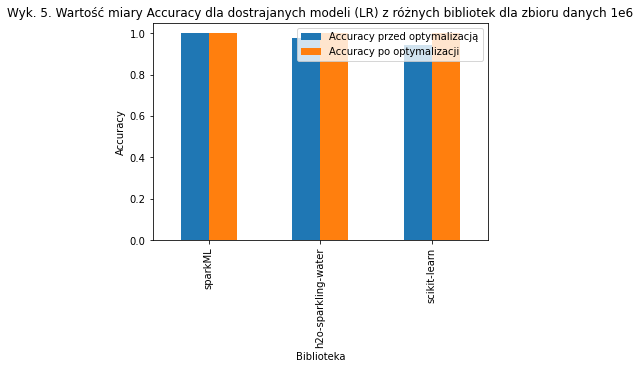

In [33]:
lr_tuned_models_accuracy_data = [
    [sparkML_lr_basic_1e6_results.accuracy, sparkML_lr_tuning_1e6_results.accuracy],
    [h2o_lr_basic_1e6_results.accuracy, h2o_lr_tuning_1e6_results.accuracy],
    [sklearn_lr_basic_1e6_results.accuracy, sklearn_lr_tuning_1e6_results.accuracy]
]

lr_tuned_models_accuracy_df = pd.DataFrame(lr_tuned_models_auc_data, columns=['Accuracy przed optymalizacją', 'Accuracy po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_tuned_models_accuracy_df.plot.bar()
plt.title('Wyk. 5. Wartość miary Accuracy dla dostrajanych modeli (LR) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [34]:
lr_tuned_models_accuracy_df

,Accuracy przed optymalizacją,Accuracy po optymalizacji
sparkML,1.000000,1.0
h2o-sparkling-water,0.975184,1.0
scikit-learn,0.943934,1.0


# **Regresja logistyczna - porównanie czasu trenowania modeli dla zbioru danych 1e6 w zależności od liczby dostępnych wątków**

Dla różnej liczby dostępnych wątków w środowisku testowym (1, 2 i 3), sprawdziliśmy czasy trenowania bazowych wersji modelów typu regresja logistyczna z bibliotek Spark, h2o-sparkling-water oraz scikit-learn. W niniejszym sprawozdaniu przedstawiliśmy wyniki dla zbioru danych 1e6

**Ze względu na problemy z resetowaniem kontekstu h2o w ramach jednego notatnika (co było konieczne do zmiany liczby dostępnych wątków), eksperymenty dla tego zadania przeprowadziliśmy w oddzielnych notatnikach, a ich wyniki przepisaliśmy do niniejszego sprawozdania. Notatniki można znaleźć w folderze tbd-notebooks/cores_testing.**

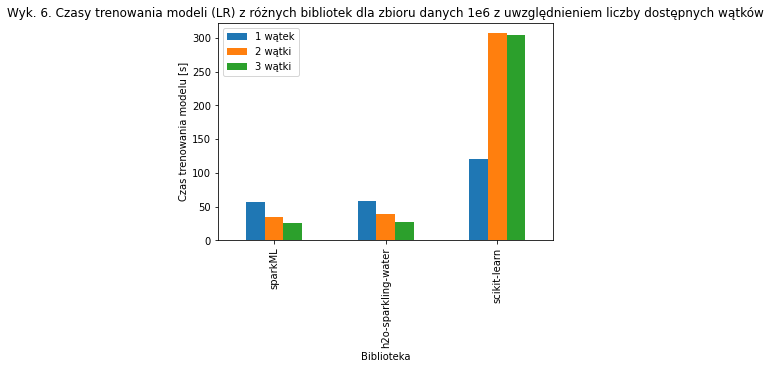

In [35]:
lr_basic_models_training_times_for_cores_data = [
    [57.245, 34.946, 25.672],
    [58.314, 38.361, 27.613],
    [119.977, 306.877, 304.123]
]

lr_basic_models_training_times_for_cores_df = pd.DataFrame(lr_basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML', 'h2o-sparkling-water', 'scikit-learn'])

lr_basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk. 6. Czasy trenowania modeli (LR) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [36]:
lr_basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML,57.245,34.946,25.672
h2o-sparkling-water,58.314,38.361,27.613
scikit-learn,119.977,306.877,304.123


## Analiza wyników

Analiza

# **Gradient Boosted Trees - porównanie wyników klasyfikacji oraz czasu trenowania podstawowych wersji modeli dla różnych wielkości zbiorów danych**

Dla każdego otrzymanego zbioru danych, przeprowadziliśmy trenowanie podstawowych wersji (z domyślnymi parametrami) modeli typu Gradient Boosted Trees. Ich implementacje zaczerpnęliśmy z trzech bibliotek: Spark, h2o-sparkling-water oraz SynapseML. Podczas trenowania mierzyliśmy jego czas, a następnie dla otrzymanych modeli sprawdziliśmy na zbiorze testowym wartości AUC, Accuracy oraz macierz pomyłek.

## Zbiór danych 1e4

In [37]:
sparkML_gbt_basic_1e4_results = test_sparkML_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_sparkML_gbt_basic_1e4_results = 'Gradient Boosted Trees, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e4_results, label_sparkML_gbt_basic_1e4_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 6.802s
AUC: 0.704
Accuracy: 0.75
Macierz pomyłek:
   label  prediction  count
0      0         0.0      1
1      0         1.0      2
2      1         0.0      1
3      1         1.0      8


In [38]:
h2o_gbt_basic_1e4_results = test_h2o_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_h2o_gbt_basic_1e4_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e4_results, label_h2o_gbt_basic_1e4_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.736s
AUC: 0.778
Accuracy: 0.667
Macierz pomyłek:
   label prediction  count
0      0          0      1
1      0          1      2
2      1          0      2
3      1          1      7


In [39]:
synapseML_gbt_basic_1e4_results = test_synapseML_gbt_basic_version(training_df_1e4, testing_df_1e4)

label_synapseML_gbt_basic_1e4_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e4_results, label_synapseML_gbt_basic_1e4_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e4, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.299s
AUC: 0.519
Accuracy: 0.667
Macierz pomyłek:
   label  prediction  count
0      0         1.0      3
1      1         0.0      1
2      1         1.0      8


## Zbiór danych 1e5

In [40]:
sparkML_gbt_basic_1e5_results = test_sparkML_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_sparkML_gbt_basic_1e5_results = 'Gradient Boosted Trees, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e5_results, label_sparkML_gbt_basic_1e5_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 7.497s
AUC: 0.97
Accuracy: 0.946
Macierz pomyłek:
   label  prediction  count
0      0         0.0      8
1      0         1.0      2
2      1         1.0     27


In [41]:
h2o_gbt_basic_1e5_results = test_h2o_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_h2o_gbt_basic_1e5_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e5_results, label_h2o_gbt_basic_1e5_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.523s
AUC: 0.844
Accuracy: 0.946
Macierz pomyłek:
   label prediction  count
0      0          0      8
1      0          1      2
2      1          1     27


In [42]:
synapseML_gbt_basic_1e5_results = test_synapseML_gbt_basic_version(training_df_1e5, testing_df_1e5)

label_synapseML_gbt_basic_1e5_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e5_results, label_synapseML_gbt_basic_1e5_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e5, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.095s
AUC: 0.852
Accuracy: 0.946
Macierz pomyłek:
   label  prediction  count
0      0         0.0      8
1      0         1.0      2
2      1         1.0     27


## Zbiór danych 1e6

In [43]:
sparkML_gbt_basic_1e6_results = test_sparkML_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_sparkML_gbt_basic_1e6_results = 'Gradient Boosted Trees, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(sparkML_gbt_basic_1e6_results, label_sparkML_gbt_basic_1e6_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 6.569s
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         1.0     68


In [44]:
h2o_gbt_basic_1e6_results = test_h2o_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_h2o_gbt_basic_1e6_results = 'Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(h2o_gbt_basic_1e6_results, label_h2o_gbt_basic_1e6_results)

----- Gradient Boosted Trees, H2O-sparkling-water, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.586s
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label prediction  count
0      0          0     16
1      1          1     68


In [45]:
synapseML_gbt_basic_1e6_results = test_synapseML_gbt_basic_version(training_df_1e6, testing_df_1e6)

label_synapseML_gbt_basic_1e6_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków'
print_model_testing_results(synapseML_gbt_basic_1e6_results, label_synapseML_gbt_basic_1e6_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e6, podstawowe hiperparametry, domyślna liczba wątków -----
Czas trenowania: 1.058s
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         1.0     68


## Analiza wyników

In [46]:
models_gbt_basic_scores_data = [
    ['1e4', 'sparkML', sparkML_gbt_basic_1e4_results.training_time, sparkML_gbt_basic_1e4_results.auc, sparkML_gbt_basic_1e4_results.accuracy],
    ['1e4', 'h2o-sparkling-water', h2o_gbt_basic_1e4_results.training_time, h2o_gbt_basic_1e4_results.auc, h2o_lr_basic_1e4_results.accuracy],
    ['1e4', 'synapseML', synapseML_gbt_basic_1e4_results.training_time, synapseML_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.accuracy],
    ['1e5', 'sparkML', sparkML_gbt_basic_1e5_results.training_time, sparkML_gbt_basic_1e5_results.auc, sparkML_gbt_basic_1e5_results.accuracy],
    ['1e5', 'h2o-sparkling-water', h2o_gbt_basic_1e5_results.training_time, h2o_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.accuracy],
    ['1e5', 'ssynapseML', synapseML_gbt_basic_1e5_results.training_time, synapseML_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.accuracy],
    ['1e6', 'sparkML', sparkML_gbt_basic_1e6_results.training_time, sparkML_gbt_basic_1e6_results.auc, sparkML_gbt_basic_1e6_results.accuracy],
    ['1e6', 'h2o-sparkling-water', h2o_gbt_basic_1e6_results.training_time, h2o_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.accuracy],
    ['1e6', 'synapseML', synapseML_gbt_basic_1e6_results.training_time, synapseML_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.accuracy],
]

models_gbt_basic_scores_df = pd.DataFrame(models_gbt_basic_scores_data, columns=['Zbiór danych', 'Biblioteka', 'Czas trenowania (s)', 'AUC', 'Accuracy'])
models_gbt_basic_scores_df

,Zbiór danych,Biblioteka,Czas trenowania (s),AUC,Accuracy
0,1e4,sparkML,6.801630,0.703704,0.750000
1,1e4,h2o-sparkling-water,1.735834,0.777778,0.750000
2,1e4,synapseML,1.298715,0.518519,0.666667
3,1e5,sparkML,7.497451,0.970370,0.945946
4,1e5,h2o-sparkling-water,1.522701,0.844444,0.945946
5,1e5,ssynapseML,1.095410,0.851852,0.945946
6,1e6,sparkML,6.568870,1.000000,1.000000
7,1e6,h2o-sparkling-water,1.586159,1.000000,1.000000
8,1e6,synapseML,1.057577,1.000000,1.000000


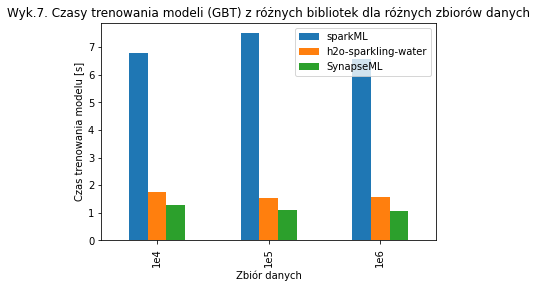

In [47]:
gbt_basic_models_training_times_data = [
    [sparkML_gbt_basic_1e4_results.training_time, h2o_gbt_basic_1e4_results.training_time, synapseML_gbt_basic_1e4_results.training_time],
    [sparkML_gbt_basic_1e5_results.training_time, h2o_gbt_basic_1e5_results.training_time, synapseML_gbt_basic_1e5_results.training_time],
    [sparkML_gbt_basic_1e6_results.training_time, h2o_gbt_basic_1e6_results.training_time, synapseML_gbt_basic_1e6_results.training_time],
]

gbt_basic_models_training_times_df = pd.DataFrame(gbt_basic_models_training_times_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_training_times_df.plot.bar()
plt.title('Wyk.7. Czasy trenowania modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

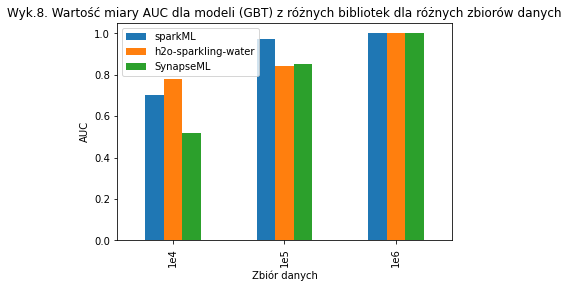

In [48]:
gbt_basic_models_auc_data = [
    [sparkML_gbt_basic_1e4_results.auc, h2o_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.auc],
    [sparkML_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.auc],
    [sparkML_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.auc],
]

gbt_basic_models_auc_df = pd.DataFrame(gbt_basic_models_auc_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_auc_df.plot.bar()
plt.title('Wyk.8. Wartość miary AUC dla modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

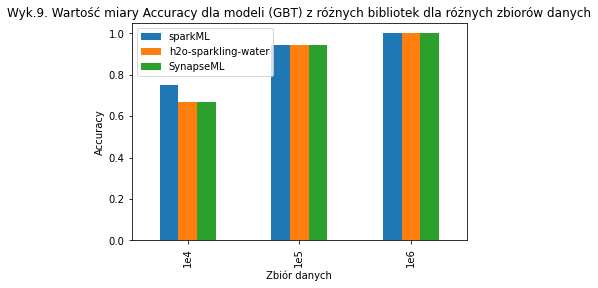

In [49]:
gbt_basic_models_accuracy_data = [
    [sparkML_gbt_basic_1e4_results.accuracy, h2o_gbt_basic_1e4_results.accuracy, synapseML_gbt_basic_1e4_results.accuracy],
    [sparkML_gbt_basic_1e5_results.accuracy, h2o_gbt_basic_1e5_results.accuracy, synapseML_gbt_basic_1e5_results.accuracy],
    [sparkML_gbt_basic_1e6_results.accuracy, h2o_gbt_basic_1e6_results.accuracy, synapseML_gbt_basic_1e6_results.accuracy],
]

gbt_basic_models_accuracy_df = pd.DataFrame(gbt_basic_models_accuracy_data, columns=['sparkML', 'h2o-sparkling-water', 'SynapseML'], index=['1e4', '1e5', '1e6'])

gbt_basic_models_accuracy_df.plot.bar()
plt.title('Wyk.9. Wartość miary Accuracy dla modeli (GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

# **Gradient Boosted Trees - optymalizacja hiperparametrów modeli na zbiorze danych 1e6**

Dla każdej badanej implementacji modelu typu Gradient Boosted Trees, spróbowaliśmy dokonać optymalizacji ich parametrów. Wyniki dla nowo otrzymanych modeli porównaliśmy z ich wersjami bazowymi. Optymalizację, trenowanie i testowanie modeli przeprowadziliśmy na zbiorze danych 1e6.

Dla każdej biblioteki dokonaliśmy optymalizacji dla różnych parametrów, z wykorzystaniem metod detykowanych dla tych bibliotek. Szczegóły w implementacjach kolejnych wywoływanych funkcji.

## sparkML

In [50]:
sparkML_gbt_tuning_1e6_results = tune_and_test_sparkML_gbt(training_df_1e6, testing_df_1e6)

label_sparkML_gbt_tuning_1e6_results = 'Gradient Boosted Trees, sparkML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(sparkML_gbt_tuning_1e6_results, label_sparkML_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, sparkML, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    maxDepth: 10
    maxBins: 64
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         1.0     68


## H2O-sparklinkg-water

In [51]:
h2o_gbt_tuning_1e6_results = tune_and_test_h2o_gbt(training_df_1e6, testing_df_1e6)

label_h2o_gbt_tuning_1e6_results = 'Gradient Boosted Trees, H2O-sparklinkg-water, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(h2o_gbt_tuning_1e6_results, label_h2o_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, H2O-sparklinkg-water, zbiór 1e6, optymalizowane hiperparametry -----
Zoptymalizowane parametry:
    learnRate: 0.4
    maxDepth: 2147483647
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label prediction  count
0      0          0     16
1      1          1     68


## SynapseML

In [52]:
synapseML_gbt_tuning_1e6_results = tune_and_test_synapseML_gbt(training_df_1e6, testing_df_1e6)

label_synapseML_gbt_tuning_1e6_results = 'Gradient Boosted Trees, SynapseML, zbiór 1e6, optymalizowane hiperparametry'
print_model_tuning_results(synapseML_gbt_tuning_1e6_results, label_synapseML_gbt_tuning_1e6_results)

----- Gradient Boosted Trees, SynapseML, zbiór 1e6, optymalizowane hiperparametry -----
AUC: 1.0
Accuracy: 1.0
Macierz pomyłek:
   label  prediction  count
0      0         0.0     16
1      1         1.0     68


## Analiza wyników

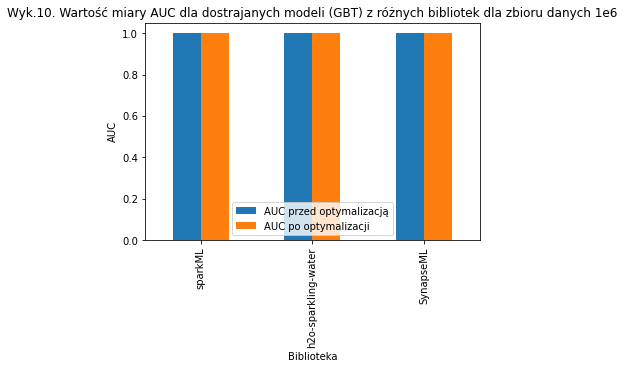

In [53]:
gbt_tuned_models_auc_data = [
    [sparkML_gbt_basic_1e6_results.auc, sparkML_gbt_tuning_1e6_results.auc],
    [h2o_gbt_basic_1e6_results.auc, h2o_gbt_tuning_1e6_results.auc],
    [synapseML_gbt_basic_1e6_results.auc, synapseML_gbt_tuning_1e6_results.auc]
]

gbt_tuned_models_auc_df = pd.DataFrame(gbt_tuned_models_auc_data, columns=['AUC przed optymalizacją', 'AUC po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_tuned_models_auc_df.plot.bar()
plt.title('Wyk.10. Wartość miary AUC dla dostrajanych modeli (GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [54]:
gbt_tuned_models_auc_df

,AUC przed optymalizacją,AUC po optymalizacji
sparkML,1.0,1.0
h2o-sparkling-water,1.0,1.0
SynapseML,1.0,1.0


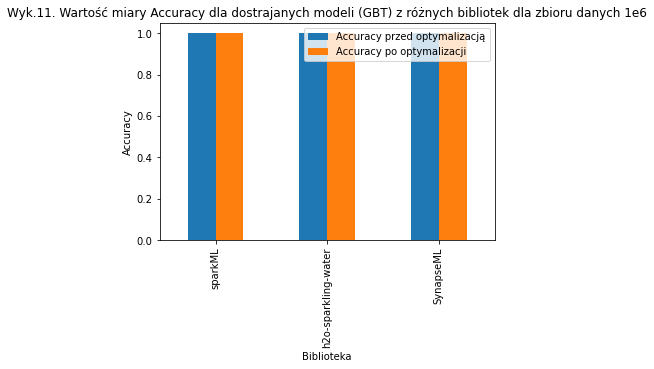

In [55]:
gbt_tuned_models_accuracy_data = [
    [sparkML_gbt_basic_1e6_results.accuracy, sparkML_gbt_tuning_1e6_results.accuracy],
    [h2o_gbt_basic_1e6_results.accuracy, h2o_gbt_tuning_1e6_results.accuracy],
    [synapseML_gbt_basic_1e6_results.accuracy, synapseML_gbt_tuning_1e6_results.accuracy]
]

gbt_tuned_models_accuracy_df = pd.DataFrame(gbt_tuned_models_accuracy_data, columns=['Accuracy przed optymalizacją', 'Accuracy po optymalizacji'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_tuned_models_accuracy_df.plot.bar()
plt.title('Wyk.11. Wartość miary Accuracy dla dostrajanych modeli (GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [56]:
gbt_tuned_models_accuracy_df

,Accuracy przed optymalizacją,Accuracy po optymalizacji
sparkML,1.0,1.0
h2o-sparkling-water,1.0,1.0
SynapseML,1.0,1.0


# **Gradient Boosted Trees - porównanie czasu trenowania modeli dla zbioru danych 1e6 w zależności od liczby dostępnych wątków**

Dla różnej liczby dostępnych wątków w środowisku testowym (1, 2 i 3), sprawdziliśmy czasy trenowania bazowych wersji modelów typu Gradient Boosted Trees z bibliotek Spark, h2o-sparkling-water oraz SynapseML. W niniejszym sprawozdaniu przedstawiliśmy wyniki dla zbioru danych 1e6

**Ze względu na problemy z resetowaniem kontekstu h2o w ramach jednego notatnika (co było konieczne do zmiany liczby dostępnych wątków), eksperymenty dla tego zadania przeprowadziliśmy w oddzielnych notatnikach, a ich wyniki przepisaliśmy do niniejszego sprawozdania. Notatniki można znaleźć w folderze tbd-notebooks/cores_testing.**

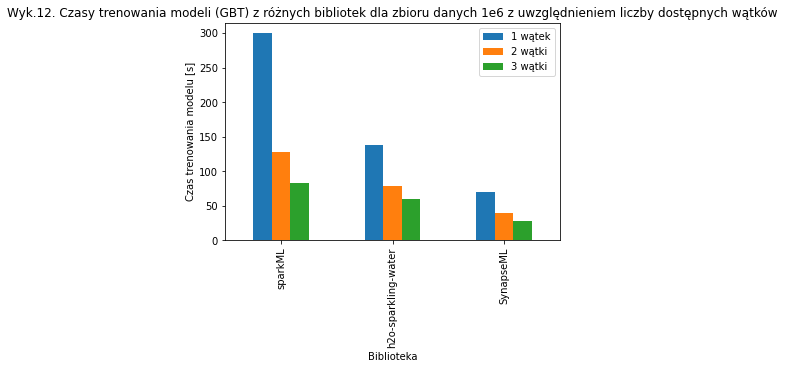

In [57]:
gbt_basic_models_training_times_for_cores_data = [
    [299.921, 127.415, 82.888],
    [137.942, 78.894, 60.38],
    [69.243, 39.783, 28.615]
]

gbt_basic_models_training_times_for_cores_df = pd.DataFrame(gbt_basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML', 'h2o-sparkling-water', 'SynapseML'])

gbt_basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk.12. Czasy trenowania modeli (GBT) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [58]:
gbt_basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML,299.921,127.415,82.888
h2o-sparkling-water,137.942,78.894,60.380
SynapseML,69.243,39.783,28.615


## Analiza wyników

Analiza

# Wnioski i podsumowanie

## Wartość miary AUC dla modeli bazowych

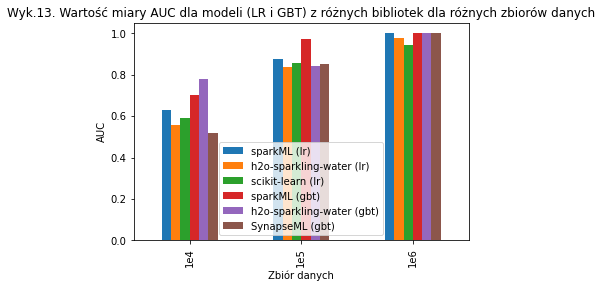

In [59]:
basic_models_auc_data = [
    [sparkML_lr_basic_1e4_results.auc, h2o_lr_basic_1e4_results.auc, sklearn_lr_basic_1e4_results.auc, sparkML_gbt_basic_1e4_results.auc, h2o_gbt_basic_1e4_results.auc, synapseML_gbt_basic_1e4_results.auc],
    [sparkML_lr_basic_1e5_results.auc, h2o_lr_basic_1e5_results.auc, sklearn_lr_basic_1e5_results.auc, sparkML_gbt_basic_1e5_results.auc, h2o_gbt_basic_1e5_results.auc, synapseML_gbt_basic_1e5_results.auc],
    [sparkML_lr_basic_1e6_results.auc, h2o_lr_basic_1e6_results.auc, sklearn_lr_basic_1e6_results.auc, sparkML_gbt_basic_1e6_results.auc, h2o_gbt_basic_1e6_results.auc, synapseML_gbt_basic_1e6_results.auc]
]

basic_models_auc_df = pd.DataFrame(basic_models_auc_data, columns=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'], index=['1e4', '1e5', '1e6'])

basic_models_auc_df.plot.bar()
plt.title('Wyk.13. Wartość miary AUC dla modeli (LR i GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('AUC')
plt.show()

In [60]:
basic_models_auc_df

,sparkML (lr),h2o-sparkling-water (lr),scikit-learn (lr),sparkML (gbt),h2o-sparkling-water (gbt),SynapseML (gbt)
1e4,0.629630,0.555556,0.592593,0.703704,0.777778,0.518519
1e5,0.874074,0.837037,0.855556,0.970370,0.844444,0.851852
1e6,1.000000,0.975184,0.943934,1.000000,1.000000,1.000000


## Wartość miary Accuracy dla modeli bazowych

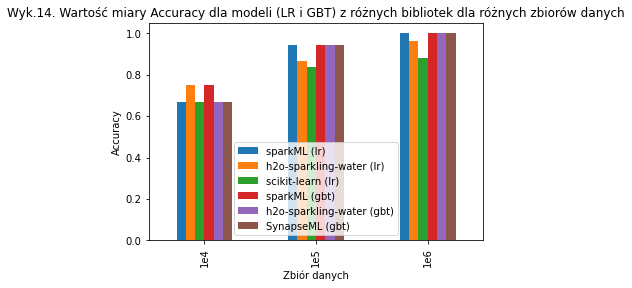

In [61]:
basic_models_accuracy_data = [
    [sparkML_lr_basic_1e4_results.accuracy, h2o_lr_basic_1e4_results.accuracy, sklearn_lr_basic_1e4_results.accuracy, sparkML_gbt_basic_1e4_results.accuracy, h2o_gbt_basic_1e4_results.accuracy, synapseML_gbt_basic_1e4_results.accuracy],
    [sparkML_lr_basic_1e5_results.accuracy, h2o_lr_basic_1e5_results.accuracy, sklearn_lr_basic_1e5_results.accuracy, sparkML_gbt_basic_1e5_results.accuracy, h2o_gbt_basic_1e5_results.accuracy, synapseML_gbt_basic_1e5_results.accuracy],
    [sparkML_lr_basic_1e6_results.accuracy, h2o_lr_basic_1e6_results.accuracy, sklearn_lr_basic_1e6_results.accuracy, sparkML_gbt_basic_1e6_results.accuracy, h2o_gbt_basic_1e6_results.accuracy, synapseML_gbt_basic_1e6_results.accuracy]
]

basic_models_accuracy_df = pd.DataFrame(basic_models_accuracy_data, columns=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'], index=['1e4', '1e5', '1e6'])

basic_models_accuracy_df.plot.bar()
plt.title('Wyk.14. Wartość miary Accuracy dla modeli (LR i GBT) z różnych bibliotek dla różnych zbiorów danych')
plt.xlabel('Zbiór danych')
plt.ylabel('Accuracy')
plt.show()

In [62]:
basic_models_accuracy_df

,sparkML (lr),h2o-sparkling-water (lr),scikit-learn (lr),sparkML (gbt),h2o-sparkling-water (gbt),SynapseML (gbt)
1e4,0.666667,0.750000,0.666667,0.750000,0.666667,0.666667
1e5,0.945946,0.864865,0.837838,0.945946,0.945946,0.945946
1e6,1.000000,0.964286,0.880952,1.000000,1.000000,1.000000


## Wartość miary AUC dla modeli optymalizowanych

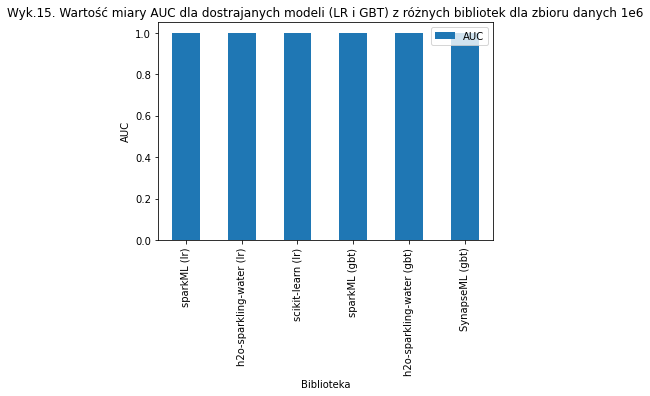

In [63]:
tuned_models_auc_data = [
    [sparkML_lr_tuning_1e6_results.auc],
    [h2o_lr_tuning_1e6_results.auc],
    [sklearn_lr_tuning_1e6_results.auc],
    [sparkML_gbt_tuning_1e6_results.auc],
    [h2o_gbt_tuning_1e6_results.auc],
    [sparkML_gbt_tuning_1e6_results.auc]
]

tuned_models_auc_df = pd.DataFrame(tuned_models_auc_data, columns=['AUC'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

tuned_models_auc_df.plot.bar()
plt.title('Wyk.15. Wartość miary AUC dla dostrajanych modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('AUC')
plt.show()

In [64]:
tuned_models_auc_df

,AUC
sparkML (lr),1.0
h2o-sparkling-water (lr),1.0
scikit-learn (lr),1.0
sparkML (gbt),1.0
h2o-sparkling-water (gbt),1.0
SynapseML (gbt),1.0


## Wartość miary Accuracy dla modeli optymalizowanych

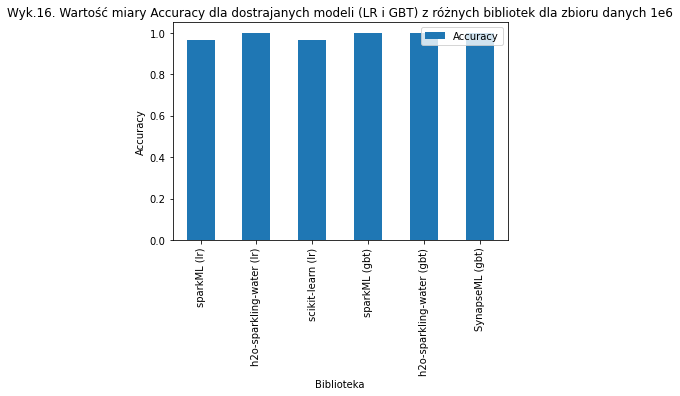

In [65]:
tuned_models_accuracy_data = [
    [sparkML_lr_tuning_1e6_results.accuracy],
    [h2o_lr_tuning_1e6_results.accuracy],
    [sklearn_lr_tuning_1e6_results.accuracy],
    [sparkML_gbt_tuning_1e6_results.accuracy],
    [h2o_gbt_tuning_1e6_results.accuracy],
    [sparkML_gbt_tuning_1e6_results.accuracy]
]

tuned_models_accuracy_df = pd.DataFrame(tuned_models_accuracy_data, columns=['Accuracy'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

tuned_models_accuracy_df.plot.bar()
plt.title('Wyk.16. Wartość miary Accuracy dla dostrajanych modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6')
plt.xlabel('Biblioteka')
plt.ylabel('Accuracy')
plt.show()

In [66]:
tuned_models_accuracy_df

,Accuracy
sparkML (lr),0.964286
h2o-sparkling-water (lr),1.000000
scikit-learn (lr),0.964286
sparkML (gbt),1.000000
h2o-sparkling-water (gbt),1.000000
SynapseML (gbt),1.000000


## Trenowanie dla różnej liczby rdzeni

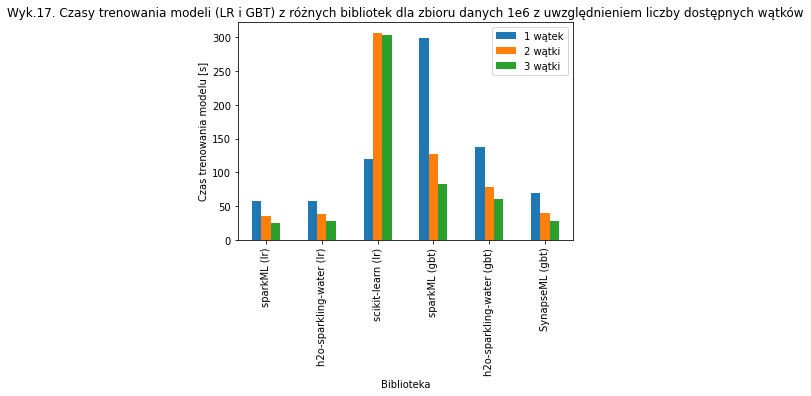

In [67]:
basic_models_training_times_for_cores_data = [
    [57.245, 34.946, 25.672],
    [58.314, 38.361, 27.613],
    [119.977, 306.877, 304.123],
    [299.921, 127.415, 82.888],
    [137.942, 78.894, 60.38],
    [69.243, 39.783, 28.615]
]

basic_models_training_times_for_cores_df = pd.DataFrame(basic_models_training_times_for_cores_data, columns=['1 wątek', '2 wątki', '3 wątki'], index=['sparkML (lr)', 'h2o-sparkling-water (lr)', 'scikit-learn (lr)', 'sparkML (gbt)', 'h2o-sparkling-water (gbt)', 'SynapseML (gbt)'])

basic_models_training_times_for_cores_df.plot.bar()
plt.title('Wyk.17. Czasy trenowania modeli (LR i GBT) z różnych bibliotek dla zbioru danych 1e6 z uwzględnieniem liczby dostępnych wątków')
plt.xlabel('Biblioteka')
plt.ylabel('Czas trenowania modelu [s]')
plt.show()

In [68]:
basic_models_training_times_for_cores_df

,1 wątek,2 wątki,3 wątki
sparkML (lr),57.245,34.946,25.672
h2o-sparkling-water (lr),58.314,38.361,27.613
scikit-learn (lr),119.977,306.877,304.123
sparkML (gbt),299.921,127.415,82.888
h2o-sparkling-water (gbt),137.942,78.894,60.380
SynapseML (gbt),69.243,39.783,28.615
